<a href="https://colab.research.google.com/github/CharlotteY2003/Recycling-Project/blob/main/Recycling_Basic_Classification_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Holds most basic version, with around 70% accuracy on test data <br>
Must download trashnet dataset and add it onto google drive

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
import os
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras import regularizers
from keras.preprocessing.image import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(os.listdir('drive/MyDrive/Trashnet/dataset-original'))

['cardboard', 'plastic', 'trash', 'paper', 'glass', 'metal']


#Necessary Functions

In [4]:
def remove_corrupt(filepath):
  skipped = 0
  for file_name in os.listdir(filepath):
    path = os.path.join(filepath, file_name)
    for file in os.listdir(path):
      fpath = os.path.join(path, file)
      obj = open(fpath, 'rb')
      is_jfif = tf.compat.as_bytes('JFIF') in obj.peek(10)
      obj.close()
      
      if not is_jfif:
        skipped+=1
        os.remove(fpath)
  print('Num instances skipped: ',skipped)

In [5]:
def build_dataset(filepath,filepath2):
  raw_train_data = tf.keras.preprocessing.image_dataset_from_directory(filepath, seed=11, validation_split=.3, 
                                                                      subset='training')
  raw_val_data = tf.keras.preprocessing.image_dataset_from_directory(filepath, seed=11, validation_split=.3, 
                                                                      subset='validation')
  
  raw_train_data2 = tf.keras.preprocessing.image_dataset_from_directory(filepath2, seed=11, validation_split=.3, 
                                                                      subset='training')
  raw_val_data2 = tf.keras.preprocessing.image_dataset_from_directory(filepath2, seed=11, validation_split=.3, 
                                                                      subset='validation')
  
  train_ds = raw_train_data.concatenate(raw_train_data2)
  val_ds = raw_val_data.concatenate(raw_val_data2)
  

  test_ds = val_ds.skip(int(.7 * 19)) #total num of files/batch size
  val_ds = val_ds.take(int(.7 * 19))

  return train_ds, val_ds,test_ds

In [6]:
def find_shape(raw_train_data):
  for images, labels in raw_train_data.take(1):
    for i in range(3):
      img = images[i].numpy().astype('uint8')
      print(img.shape)
      if i==2:
        return img.shape

In [7]:
def display_data(raw_train_data, feature_names):
  plt.figure(figsize=(10,10))

  for images,labels in raw_train_data.take(1):
    for i in range(9):
      ax = plt.subplot(3,3,i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(feature_names[int(labels[i])-1])
      #plt.title(int(labels[i])-1)
      plt.axis('off')

In [8]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.1),
  Normalization(),
  RandomTranslation((.2,.3),(.2,.3),fill_mode='nearest'),
  Rescaling(1.0/255),
])

In [9]:
def build_model(input_shape, num_classes):
  #add regularization and dropout
  #displaying signs of overfitting

  inputs = Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = Rescaling(1.0/255)(x)

  for filter in [64,128,256,512,1024]:
    x = Conv2D(filter, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPool2D(padding='same')(x)
    x = BatchNormalization()(x)

  x = Flatten()(x)
  x = Dense(728, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4))(x)
  x = BatchNormalization()(x)
  x = Dropout(.3)(x)
  outputs = Dense(num_classes, activation='softmax')(x)
  
  model = keras.Model(inputs, outputs)

  model.summary()

  optimizer = RMSprop(momentum=.9)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [10]:
def train_model(model, raw_train_data,validation_data):
  es = EarlyStopping(min_delta=0, patience=1, mode='min', restore_best_weights=True)
  history = model.fit(raw_train_data, validation_data=validation_data, batch_size=32, epochs=10, verbose=1, callbacks=[es])
  return model, history

In [11]:
def display_metrics(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(acc, label='training', color='blue')
  plt.plot(val_acc, label='validation', color='orange')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  plt.plot(loss, label='training', color='blue')
  plt.plot(val_loss, label='validation', color='orange')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

In [12]:
def display_predictions(model, feature_names):
  predictions = model.predict(test_data)
  probs = model.predict_proba(test_data)

  for images,labels in test_data.take(1):
    for i in range(9):
      ax = plt.subplot(3,3,i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      pred = np.argmax((predictions[i]))
      plt.title(feature_names[int(pred)-1], "-", probs[i])
      plt.axis('off')

#Build Recycling Classifier

In [13]:
filepath = 'drive/MyDrive/Trashnet/dataset-original'
filepath2 = 'drive/MyDrive/garbage_classification/Garbage classification/Garbage classification'
feature_names = ['glass', 'metal', 'paper', 'plastic', 'trash', 'cardboard']
num_classes = len(feature_names)
print(feature_names)

['glass', 'metal', 'paper', 'plastic', 'trash', 'cardboard']


Num instances skipped:  0
Num instances skipped:  0
Found 2090 files belonging to 6 classes.
Using 1463 files for training.
Found 2090 files belonging to 6 classes.
Using 627 files for validation.
Found 2527 files belonging to 6 classes.
Using 1769 files for training.
Found 2527 files belonging to 6 classes.
Using 758 files for validation.
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


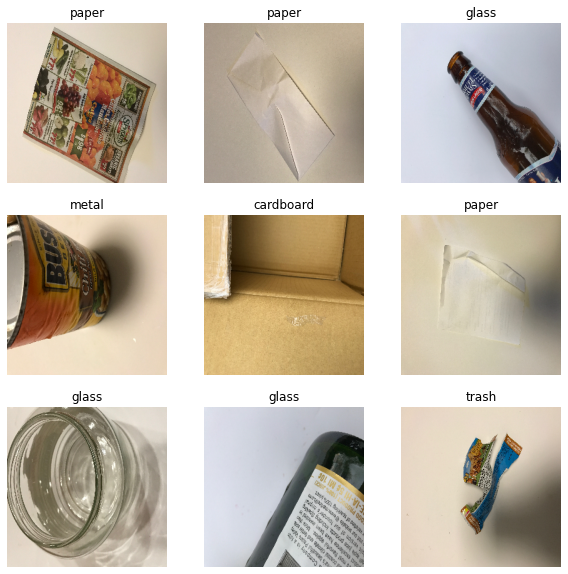

In [14]:
remove_corrupt(filepath)
remove_corrupt(filepath2)
train_ds, val_ds, test_ds = build_dataset(filepath,filepath2)
display_data(train_ds, feature_names)
input_shape = find_shape(train_ds)

In [ ]:
model = build_model(input_shape, num_classes)
model, history = train_model(model,train_ds, val_ds)
display_metrics(history)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 256, 256, 3)       7         
_________________________________________________________________
random_translation (RandomTr (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0     

In [ ]:
print(model.evaluate(test_ds))

In [ ]:
display_predictions(model)

#Build plastic sub classification

In [ ]:
filepath = 'drive/MyDrive/recycling/garbage_classification'
remove_corrupted(filepath)
feature_names = ['biological', 'brown-glass', 'cardboard', 'clothes', 'battery']
plas_train_ds, plas_val_ds, plas_test_ds = build_dataset(filepath)
display_data(plas_train_ds, feature_names)
input_shape = find_shape(plas_train_ds)

In [ ]:
plas_model = build_model(input_shape)
plas_model, history = train_model(plas_model)
display_metrics(history)

In [ ]:
print(plas_model.evaluate(plas_test_ds))

In [ ]:
display_predictions(plas_model)